In [455]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import skew, kurtosis
from sklearn.model_selection import KFold
import optuna 
warnings.filterwarnings('ignore')

from functools import partial
import random
import numpy as np
from utils import round
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from tqdm import tqdm 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [12]:
train_home_team_statistics_df = pd.read_csv('./datas_final/train_home_team_statistics_df.csv', index_col=0)
train_away_team_statistics_df = pd.read_csv('./datas_final/train_away_team_statistics_df.csv', index_col=0)

train_scores = pd.read_csv('./datas_final/Y_train.csv', index_col=0)

train_home = train_home_team_statistics_df.iloc[:,2:]
train_away = train_away_team_statistics_df.iloc[:,2:]

train_home.columns = 'HOME_' + train_home.columns
train_away.columns = 'AWAY_' + train_away.columns

train_data =  pd.concat([train_home,train_away],join='inner',axis=1)
train_scores = train_scores.loc[train_data.index]

train_data = train_data.replace({np.inf:np.nan,-np.inf:np.nan})
features_train = train_data.columns.tolist() #home and away should be symmetric 


In [34]:
brest_rows = train_home_team_statistics_df[train_home_team_statistics_df['TEAM_NAME'] == 'Brest']
print(brest_rows)

        LEAGUE TEAM_NAME  TEAM_SHOTS_TOTAL_season_sum  \
ID                                                      
1      Ligue 2     Brest                          6.0   
61     Ligue 1     Brest                          3.0   
68     Ligue 1     Brest                          4.0   
702    Ligue 2     Brest                          6.0   
986    Ligue 1     Brest                          4.0   
1129   Ligue 1     Brest                          4.0   
1353   Ligue 1     Brest                          4.0   
1476   Ligue 2     Brest                          6.0   
1493   Ligue 1     Brest                          3.0   
2390   Ligue 1     Brest                          2.0   
2502   Ligue 1     Brest                          4.0   
2719   Ligue 1     Brest                          4.0   
2984   Ligue 1     Brest                          5.0   
4150   Ligue 1     Brest                          9.0   
4182   Ligue 2     Brest                          7.0   
5525   Ligue 2     Brest       

In [10]:
test_home_team_statistics_df = pd.read_csv('./Test_Data/test_home_team_statistics_df.csv', index_col=0)
test_away_team_statistics_df = pd.read_csv('./Test_Data/test_away_team_statistics_df.csv', index_col=0)

test_home = test_home_team_statistics_df.iloc[:,2:]
test_away = test_away_team_statistics_df.iloc[:,2:]

test_home.columns = 'HOME_' + test_home.columns
test_away.columns = 'AWAY_' + test_away.columns

test_data =  pd.concat([test_home,test_away],join='inner',axis=1)

test_data = test_data.replace({np.inf:np.nan,-np.inf:np.nan})
features_test = test_data.columns.tolist()


In [191]:
train_home_player_statistics_df = pd.read_csv('./datas_final/train_home_player_statistics_df.csv', index_col=0)
train_away_player_statistics_df = pd.read_csv('./datas_final/train_away_player_statistics_df.csv', index_col=0)

In [192]:
test_home_player_statistics_df = pd.read_csv('./Test_Data/test_home_player_statistics_df.csv', index_col=0)
test_away_player_statistics_df = pd.read_csv('./Test_Data/test_away_player_statistics_df.csv', index_col=0)

In [8]:
#### Number of data in the train and testing set 

train_data.shape, test_data.shape ### same number of training data and testing data, 280 features only if we do not consider the players

((12303, 280), (12303, 280))

In [21]:
### features 
print(len(features_train), len(features_test)) 
print('Features unique to the training data:', [feature for feature in features_train if feature not in features_test])
print('Features unique to the testing data:', [feature for feature in features_test if feature not in features_train])
### not necessary to consider these features since they are not includedin the testing set 

280 276
Features unique to the training data: ['HOME_TEAM_SHOTS_TOTAL_season_sum', 'HOME_TEAM_SHOTS_INSIDEBOX_season_sum', 'AWAY_TEAM_SHOTS_TOTAL_season_sum', 'AWAY_TEAM_SHOTS_INSIDEBOX_season_sum']
Features unique to the testing data: []


In [23]:
#### we only consider the testing variables 
train_data = train_data[features_test]
train_data.shape

(12303, 276)

In [27]:
features = features_test

In [146]:
train_home_team_statistics_df.head()

,LEAGUE,TEAM_NAME,TEAM_SHOTS_TOTAL_season_sum,TEAM_SHOTS_INSIDEBOX_season_sum,TEAM_SHOTS_OFF_TARGET_season_sum,TEAM_SHOTS_ON_TARGET_season_sum,TEAM_SHOTS_OUTSIDEBOX_season_sum,TEAM_PASSES_season_sum,TEAM_SUCCESSFUL_PASSES_season_sum,TEAM_SAVES_season_sum,...,TEAM_YELLOWCARDS_5_last_match_std,TEAM_REDCARDS_5_last_match_std,TEAM_OFFSIDES_5_last_match_std,TEAM_ATTACKS_5_last_match_std,TEAM_PENALTIES_5_last_match_std,TEAM_SUBSTITUTIONS_5_last_match_std,TEAM_BALL_SAFE_5_last_match_std,TEAM_DANGEROUS_ATTACKS_5_last_match_std,TEAM_INJURIES_5_last_match_std,TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,Ligue 1,Toulouse,3.0,2.0,5.0,2.0,1.0,2.0,2.0,5.0,...,3.0,0.0,6.0,0.0,10.0,8.0,7.0,2.0,4.0,3.0
1,Ligue 2,Brest,6.0,8.0,3.0,6.0,5.0,8.0,7.0,10.0,...,4.0,0.0,4.0,3.0,10.0,0.0,1.0,2.0,8.0,4.0
2,Serie A,Sampdoria,4.0,2.0,5.0,2.0,8.0,1.0,1.0,2.0,...,4.0,5.0,6.0,3.0,6.0,7.0,2.0,3.0,2.0,4.0
3,League One,Coventry City,7.0,5.0,5.0,6.0,6.0,9.0,9.0,2.0,...,4.0,0.0,1.0,8.0,8.0,5.0,5.0,5.0,NaN,6.0
4,Premier League,Wolverhampton Wanderers,3.0,3.0,2.0,3.0,4.0,4.0,3.0,4.0,...,1.0,0.0,2.0,5.0,8.0,7.0,2.0,6.0,4.0,4.0


# Distribution of the features

## Number of Nans

### train

44

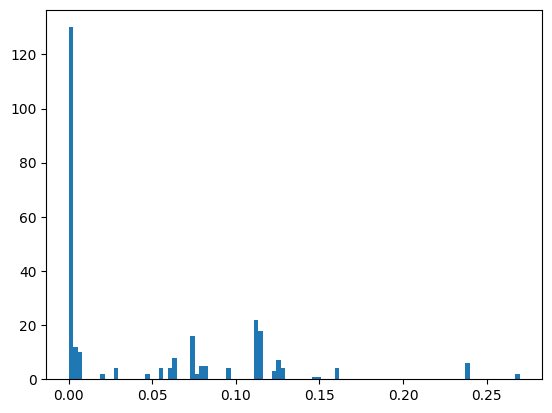

In [36]:
plt.hist(train_data.isna().sum().to_numpy() / train_data.shape[0], bins = 100)#, train_data.isna().sum() / train_data.shape[0]*
(train_data.isna().sum().to_numpy() / train_data.shape[0] == 0).sum()

In [28]:
aa = (train_data.isna().sum().to_numpy() / train_data.shape[0] > .15)
features_train_missing = np.array(features)[aa.tolist()]
print(features_train_missing)

['HOME_TEAM_INJURIES_season_sum' 'HOME_TEAM_INJURIES_season_average'
 'HOME_TEAM_INJURIES_season_std' 'HOME_TEAM_INJURIES_5_last_match_sum'
 'HOME_TEAM_INJURIES_5_last_match_average'
 'HOME_TEAM_INJURIES_5_last_match_std' 'AWAY_TEAM_INJURIES_season_sum'
 'AWAY_TEAM_INJURIES_season_average' 'AWAY_TEAM_INJURIES_season_std'
 'AWAY_TEAM_INJURIES_5_last_match_sum'
 'AWAY_TEAM_INJURIES_5_last_match_average'
 'AWAY_TEAM_INJURIES_5_last_match_std']


We observe that most of the missing data are data about injuries. This is a shame as those variables are really important to predict an outcome of a match, it is often used by the bookmakers, especially when a major player of a team is injured. 

### test

8

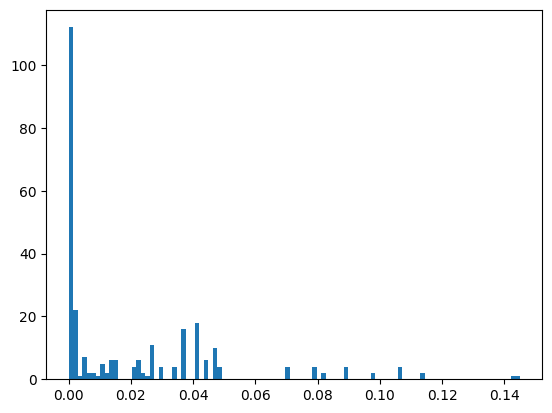

In [90]:
plt.hist(test_data.isna().sum().to_numpy() / test_data.shape[0], bins = 100)#, train_data.isna().sum() / train_data.shape[0]*
(test_data.isna().sum().to_numpy() / test_data.shape[0] > .1).sum()

In [91]:
aa = (test_data.isna().sum().to_numpy() / test_data.shape[0] > .1)
features_test_missing = np.array(features)[aa.tolist()]
features_test_missing

array(['HOME_TEAM_INJURIES_5_last_match_sum',
       'HOME_TEAM_INJURIES_5_last_match_average',
       'HOME_TEAM_BALL_SAFE_5_last_match_std',
       'HOME_TEAM_INJURIES_5_last_match_std',
       'AWAY_TEAM_INJURIES_5_last_match_sum',
       'AWAY_TEAM_INJURIES_5_last_match_average',
       'AWAY_TEAM_BALL_SAFE_5_last_match_std',
       'AWAY_TEAM_INJURIES_5_last_match_std'], dtype='<U59')

Conclusion: Either find a suitable strategy to replace the Nan, either do not consider such variables as we lack too much information. 

## Scales of the features

In [133]:
unique_values = []
for feature in features:
    unique_values.append(np.unique(train_data[feature][~np.isnan(train_data[feature])]).shape[0]) 

array([ 18.,   5., 253.])

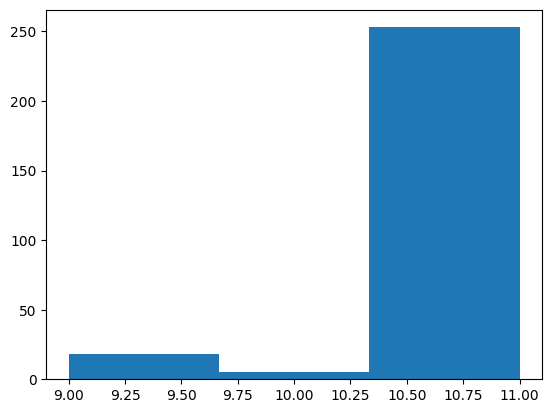

In [144]:
count = plt.hist(unique_values, bins = np.unique(unique_values).shape[0])
count[0]

Conclusion: all values have range between 0 and 10, integer. Some features do not possess all the integers in that interval, but that is uncommon. 

## Sanity check: symmetry of the distribution of the home and away features

In [87]:
### en vrai un peu too much, car c'est vraiment des variables qui peuvent prendre 11 valeurs

def compare_moments(train_data_home, train_data_away, features_home, features_away):
    df1, df2 = train_data_home.copy(), train_data_away.copy()
    comparison = pd.DataFrame(index=[feature[5:] for feature in features_home], columns=['N_nan1', 'N_nan2', 'Mean1', 'Mean2', 'Var1', 'Var2', 'Skew1', 'Skew2', 'Kurt1', 'Kurt2'])

    for idx in range(len(features_home)):
        feature_home, feature_away, feature = features_home[idx], features_away[idx], features_home[idx][5:]
        values_home, values_away = df1[feature_home].to_numpy(), df2[feature_away].to_numpy()
        comparison.at[feature, 'N_nan1'] = np.isnan(values_home).sum()
        comparison.at[feature, 'N_nan2'] = np.isnan(values_away).sum()

        values_home, values_away = values_home[~np.isnan(values_home)], values_away[~np.isnan(values_away)] #remove the nan to compute the moments     
        comparison.at[feature, 'Mean1'] = values_home.mean()
        comparison.at[feature, 'Mean2'] = values_away.mean()
        comparison.at[feature, 'Var1'] = values_home.var()
        comparison.at[feature, 'Var2'] = values_away.var()
        comparison.at[feature, 'Skew1'] = skew(values_home)
        comparison.at[feature, 'Skew2'] = skew(values_away)
        comparison.at[feature, 'Kurt1'] = kurtosis(values_home)
        comparison.at[feature, 'Kurt2'] = kurtosis(values_away)
        
    return comparison

In [41]:
features = train_data.columns.tolist() #home and away should be symmetric 
features_home, features_away = [feature for feature in features if feature.split('_')[0] == 'HOME'], [feature for feature in features if feature.split('_')[0] == 'AWAY']
len(features_home), len(features_away)

(138, 138)

In [43]:
train_data_home, train_data_away = train_data[features_home], train_data[features_away]

In [63]:
for idx in range(len(features_home)):
    print(idx)
    statistic, p_value = stats.ks_2samp(train_data_home[features_home[idx]], train_data_away[features_away[idx]])
    print(f"Feature: {idx}, KS Statistic: {statistic}, P-Value: {p_value}")

0
Feature: 0, KS Statistic: 0.01422417296594325, P-Value: 0.16425339390990823
1
Feature: 1, KS Statistic: 0.010403966512232798, P-Value: 0.5149190180904335
2
Feature: 2, KS Statistic: 0.01284239616353744, P-Value: 0.26004703772282367
3
Feature: 3, KS Statistic: 0.012842396163537328, P-Value: 0.2600470377228331
4
Feature: 4, KS Statistic: 0.012679834186783645, P-Value: 0.27359629866351676
5
Feature: 5, KS Statistic: 0.008778346744696353, P-Value: 0.7267588907781861
6
Feature: 6, KS Statistic: 0.005283264244493213, P-Value: 0.995094102413647
7
Feature: 7, KS Statistic: 0.007396569942290543, P-Value: 0.886871182666131
8
Feature: 8, KS Statistic: 0.014386734942696822, P-Value: 0.15511394426689762
9
Feature: 9, KS Statistic: 0.0035763634885800366, P-Value: 0.9999982666055263
10
Feature: 10, KS Statistic: 0.011379338372754622, P-Value: 0.4001558043849973
11
Feature: 11, KS Statistic: 0.00674632203527592, P-Value: 0.9403847024296159
12
Feature: 12, KS Statistic: 0.004958140290985957, P-Value:

In [88]:
comp = compare_moments(train_data_home, train_data_away, features_home, features_away)
comp

,N_nan1,N_nan2,Mean1,Mean2,Var1,Var2,Skew1,Skew2,Kurt1,Kurt2
TEAM_SHOTS_OFF_TARGET_season_sum,0,0,4.511339,4.591238,7.877605,7.877699,0.252143,0.228185,-0.730159,-0.750685
TEAM_SHOTS_ON_TARGET_season_sum,2,2,4.150882,4.222746,8.186323,8.26044,0.451694,0.4311,-0.668018,-0.692443
TEAM_SHOTS_OUTSIDEBOX_season_sum,1387,1389,4.524643,4.585487,8.094024,8.167559,0.236534,0.206141,-0.744858,-0.770601
TEAM_PASSES_season_sum,1413,1417,4.350597,4.3781,8.456145,8.53718,0.357608,0.345544,-0.80454,-0.834626
TEAM_SUCCESSFUL_PASSES_season_sum,1384,1385,4.130049,4.153874,8.412064,8.491252,0.448828,0.439954,-0.71304,-0.737065
...,...,...,...,...,...,...,...,...,...,...
TEAM_SUBSTITUTIONS_5_last_match_std,91,91,3.303144,3.271536,11.220255,11.122141,0.573893,0.583501,-0.941402,-0.92715
TEAM_BALL_SAFE_5_last_match_std,1795,1836,3.797868,3.804911,8.214377,8.198111,0.561538,0.557205,-0.575604,-0.568799
TEAM_DANGEROUS_ATTACKS_5_last_match_std,0,0,3.694302,3.758026,7.717408,7.92186,0.606159,0.593655,-0.418114,-0.451973
TEAM_INJURIES_5_last_match_std,3318,3313,3.865331,3.886207,7.795776,7.816528,0.530549,0.521316,-0.395737,-0.425727


# Preprocessing

## The Nan

Either remove the variable, or either replace these values. 

In [177]:
### replacing by the mean values, rounded to the closest integer. Other strategy : sampling according to the empirical distribution ? 
### Especially if you have like correlations with other variables, but that is too deep I think, I mean it requires to wor a lot of time on it
### so that should be unceserray 
### Note that replacing by the mean if also equivalent at puting the value 4 for the missing values

In [304]:
type(5) == int

True

In [305]:
def preprocess(train_data, test_data, strat = 'average', return_means = False):

    assert strat in ['remove', 'average'] or type(strat) == int, 'strat should be either remove or average'
    means = []
    features = train_data.columns
    df_train, df_test = train_data.copy(), test_data.copy()
    for feature in features:
        value = 0 
        if strat == 'average':
            value = (train_data[feature][~np.isnan(train_data[feature])].sum() + test_data[feature][~np.isnan(test_data[feature])].sum()) / ((~np.isnan(train_data[feature])).sum() + (~np.isnan(test_data[feature])).sum())
            means.append(value)
            value = round(value)
        elif type(strat) == int:
            value = strat
        df_train[feature][np.isnan(train_data[feature])],  df_test[feature][np.isnan(test_data[feature])]= value, value
    if return_means: return df_train, df_test, means
    return df_train, df_test



In [307]:
# processed_train, processed_test, means = preprocess(train_data, test_data, strat = 'average', return_means=True)
processed_train, processed_test = preprocess(train_data, test_data, strat = -1)

In [308]:
processed_train

,HOME_TEAM_SHOTS_OFF_TARGET_season_sum,HOME_TEAM_SHOTS_ON_TARGET_season_sum,HOME_TEAM_SHOTS_OUTSIDEBOX_season_sum,HOME_TEAM_PASSES_season_sum,HOME_TEAM_SUCCESSFUL_PASSES_season_sum,HOME_TEAM_SAVES_season_sum,HOME_TEAM_CORNERS_season_sum,HOME_TEAM_FOULS_season_sum,HOME_TEAM_YELLOWCARDS_season_sum,HOME_TEAM_REDCARDS_season_sum,...,AWAY_TEAM_YELLOWCARDS_5_last_match_std,AWAY_TEAM_REDCARDS_5_last_match_std,AWAY_TEAM_OFFSIDES_5_last_match_std,AWAY_TEAM_ATTACKS_5_last_match_std,AWAY_TEAM_PENALTIES_5_last_match_std,AWAY_TEAM_SUBSTITUTIONS_5_last_match_std,AWAY_TEAM_BALL_SAFE_5_last_match_std,AWAY_TEAM_DANGEROUS_ATTACKS_5_last_match_std,AWAY_TEAM_INJURIES_5_last_match_std,AWAY_TEAM_GOALS_5_last_match_std
ID,,,,,,,,,,,,,,,,,,,,,
0,5.0,2.0,1.0,2.0,2.0,5.0,3.0,6.0,2.0,2.0,...,5.0,5.0,4.0,0.0,6.0,8.0,4.0,3.0,2.0,3.0
1,3.0,6.0,5.0,8.0,7.0,10.0,6.0,8.0,3.0,0.0,...,0.0,0.0,3.0,1.0,8.0,4.0,10.0,0.0,5.0,3.0
2,5.0,2.0,8.0,1.0,1.0,2.0,2.0,7.0,7.0,6.0,...,6.0,10.0,4.0,4.0,0.0,8.0,3.0,0.0,9.0,6.0
3,5.0,6.0,6.0,9.0,9.0,2.0,2.0,0.0,0.0,6.0,...,0.0,0.0,1.0,2.0,0.0,5.0,6.0,3.0,-1.0,2.0
4,2.0,3.0,4.0,4.0,3.0,4.0,4.0,7.0,4.0,6.0,...,1.0,0.0,4.0,4.0,9.0,4.0,1.0,4.0,6.0,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12298,3.0,4.0,7.0,4.0,4.0,3.0,2.0,2.0,4.0,0.0,...,5.0,5.0,0.0,1.0,6.0,10.0,1.0,1.0,-1.0,2.0
12299,3.0,1.0,5.0,1.0,1.0,9.0,1.0,10.0,10.0,10.0,...,7.0,5.0,2.0,2.0,0.0,0.0,1.0,6.0,9.0,1.0
12300,5.0,3.0,5.0,1.0,1.0,6.0,1.0,8.0,10.0,10.0,...,8.0,0.0,3.0,2.0,0.0,0.0,6.0,3.0,4.0,4.0


# Model

## train, valid, test split

In [189]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, train_new_y, train_size=0.8, random_state=42)
X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

## Multi-class

In [204]:
### producing the vectors of labels

labels = train_scores.copy()
labels['class'] = labels.idxmax(axis=1)
label_mapping = {'HOME_WINS': 0, 'DRAW': 1, 'AWAY_WINS': 2}
labels['class'] = labels['class'].map(label_mapping)
labels = labels.drop(['HOME_WINS', 'DRAW', 'AWAY_WINS'], axis=1)

### without a valid set

In [207]:
X_train, X_test, y_train, y_test = train_test_split(processed_train, labels, test_size=0.2, random_state=42)

In [212]:
### model

params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softmax',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }

model = xgb.XGBClassifier(params_1)
model.fit(X_train, y_train)
# d_train = xgb.DMatrix(X_train.replace({0:np.nan}), y_train)
# d_valid = xgb.DMatrix(X_valid.replace({0:np.nan}), y_valid)

# num_round = 20000
# evallist = [(d_train, 'train'), (d_valid, 'eval')]

# bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [213]:
# Make predictions
predictions = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy * 100.0}%")

Accuracy: 46.93214140593255%


### with a valid set

In [368]:
# X_train, X_test, y_train, y_test = model_selection.train_test_split(processed_train, labels, train_size=0.8, random_state=42)
X_train, X_test, y_train, y_test = model_selection.train_test_split(train_data, labels, train_size=0.8, random_state=42)

X_train, X_valid, y_train, y_valid = model_selection.train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [430]:
params_1 = {
    'booster': 'gbtree',
    'tree_method':'gpu_hist',
    # 'n_estimators': 1000,
    'max_depth': 5, 
    'learning_rate': 0.025,
    'objective': 'multi:softmax',
    # 'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss',
    'min_child_weight': 1,
    'gamma': 0,
    'subsample': 0.5,
    'colsample_bytree': 1
    # 'eval_metric':'merror'
    }


# d_train = xgb.DMatrix(X_train.replace({-1:np.nan}), y_train) ## change here the values. It seems that the only viable way is to 
# d_valid = xgb.DMatrix(X_valid.replace({-1:np.nan}), y_valid) ## put a values indicating we do not have information, the mean does not work
d_train = xgb.DMatrix(X_train, y_train)
d_valid = xgb.DMatrix(X_valid, y_valid)
# d_train = xgb.DMatrix(X_train.replace({np.nan:-999}), y_train) ## change here the values. It seems that the only viable way is to 
# d_valid = xgb.DMatrix(X_valid.replace({np.nan:-999}), y_valid)

num_round = 10_000
evallist = [(d_train, 'train'), (d_valid, 'eval')]

bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)
# bst = xgb.train(params_1, d_train, num_round, verbose_eval=True)


[0]	train-mlogloss:1.09460	eval-mlogloss:1.09557
[1]	train-mlogloss:1.09066	eval-mlogloss:1.09276
[2]	train-mlogloss:1.08693	eval-mlogloss:1.08999
[3]	train-mlogloss:1.08326	eval-mlogloss:1.08741
[4]	train-mlogloss:1.07949	eval-mlogloss:1.08451
[5]	train-mlogloss:1.07600	eval-mlogloss:1.08204
[6]	train-mlogloss:1.07212	eval-mlogloss:1.07951
[7]	train-mlogloss:1.06856	eval-mlogloss:1.07731
[8]	train-mlogloss:1.06528	eval-mlogloss:1.07514
[9]	train-mlogloss:1.06207	eval-mlogloss:1.07311
[10]	train-mlogloss:1.05890	eval-mlogloss:1.07158
[11]	train-mlogloss:1.05576	eval-mlogloss:1.06992
[12]	train-mlogloss:1.05266	eval-mlogloss:1.06788
[13]	train-mlogloss:1.04964	eval-mlogloss:1.06599
[14]	train-mlogloss:1.04675	eval-mlogloss:1.06437
[15]	train-mlogloss:1.04397	eval-mlogloss:1.06276
[16]	train-mlogloss:1.04115	eval-mlogloss:1.06102
[17]	train-mlogloss:1.03833	eval-mlogloss:1.05895
[18]	train-mlogloss:1.03562	eval-mlogloss:1.05743
[19]	train-mlogloss:1.03301	eval-mlogloss:1.05572
[20]	train

In [429]:
X_test_xgb = xgb.DMatrix(X_test)
predictions = bst.predict(X_test_xgb, iteration_range=(0, bst.best_iteration))
# predictions = bst.predict(X_test_xgb)
predictions = pd.DataFrame(predictions)
np.round(accuracy_score(predictions,y_test),4)


0.4965

In [410]:
X_train_xgb = xgb.DMatrix(X_train)
predictions = bst.predict(X_train_xgb, iteration_range=(0, bst.best_iteration))
# predictions = bst.predict(X_test_xgb)
predictions = pd.DataFrame(predictions)
np.round(accuracy_score(predictions,y_train),4)


0.6891

In [411]:
X_valid_xgb = xgb.DMatrix(X_valid)
predictions = bst.predict(X_valid_xgb, iteration_range=(0, bst.best_iteration))
# predictions = bst.predict(X_test_xgb)
predictions = pd.DataFrame(predictions)
np.round(accuracy_score(predictions,y_valid),4)


0.5013

In [259]:
X_valid_xgb = xgb.DMatrix(X_valid)
predictions = bst.predict(X_valid_xgb, iteration_range=(0, bst.best_iteration))
# predictions = bst.predict(X_test_xgb)
predictions = pd.DataFrame(predictions)
np.round(accuracy_score(predictions,y_valid),4)


0.4911

In [255]:
np.round(accuracy_score(predictions,y_test),4)

0.4815

Conclusion: it really seems that, for an ensemble model, we need to not replace the nan values with possible values. This really harms the performance of the model. Let the Nan values when using xgboost. It works better. 

## Using cross-val and ensemble

In [347]:
### allow to have an ensemble method, to try to obtain the best results

kf = KFold(n_splits=10, shuffle=True, random_state=42)
res = []
params_1 = {
    'booster': 'gbtree',
    'tree_method':'hist',
    'max_depth': 8, 
    'learning_rate': 0.025,
    'objective': 'multi:softmax',
    # 'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss'
    }

fold = -1 
for (train_index, val_index) in tqdm(kf.split(train_data)):
    fold += 1 
    # X_train, X_valid = train_data[train_index], train_data[val_index]
    X_train, X_valid = train_data.iloc[train_index], train_data.iloc[val_index]
    # y_train, y_valid = labels[train_index], labels[val_index]
    y_train, y_valid = labels.iloc[train_index], labels.iloc[val_index]

    # Now you can use X_train, y_train for training and X_val, y_val for validation
    # Example: train a model, evaluate it, etc.

    print(f"Processing fold {fold + 1}...")
    # Add your model training and evaluation code here

    d_train = xgb.DMatrix(X_train, y_train)
    d_valid = xgb.DMatrix(X_valid, y_valid)

    num_round = 20_000
    evallist = [(d_train, 'train'), (d_valid, 'eval')]

    bst = xgb.train(params_1, d_train, num_round, evallist, early_stopping_rounds=100)
    # bst = xgb.train(params_1, d_train, num_round, verbose_eval=True)
    X_valid_xgb = xgb.DMatrix(X_valid)
    predictions = bst.predict(X_valid_xgb, iteration_range=(0, bst.best_iteration))
    # predictions = bst.predict(X_test_xgb)
    predictions = pd.DataFrame(predictions)
    res.append(np.round(accuracy_score(predictions,y_valid),4))


0it [00:00, ?it/s]

Processing fold 1...
[0]	train-mlogloss:1.09019	eval-mlogloss:1.09549
[1]	train-mlogloss:1.08200	eval-mlogloss:1.09289
[2]	train-mlogloss:1.07380	eval-mlogloss:1.09015
[3]	train-mlogloss:1.06620	eval-mlogloss:1.08738
[4]	train-mlogloss:1.05853	eval-mlogloss:1.08458
[5]	train-mlogloss:1.05100	eval-mlogloss:1.08232
[6]	train-mlogloss:1.04396	eval-mlogloss:1.08011
[7]	train-mlogloss:1.03712	eval-mlogloss:1.07803
[8]	train-mlogloss:1.03008	eval-mlogloss:1.07596
[9]	train-mlogloss:1.02326	eval-mlogloss:1.07398
[10]	train-mlogloss:1.01632	eval-mlogloss:1.07241
[11]	train-mlogloss:1.00966	eval-mlogloss:1.07048
[12]	train-mlogloss:1.00330	eval-mlogloss:1.06859
[13]	train-mlogloss:0.99687	eval-mlogloss:1.06704
[14]	train-mlogloss:0.99078	eval-mlogloss:1.06522
[15]	train-mlogloss:0.98487	eval-mlogloss:1.06341
[16]	train-mlogloss:0.97892	eval-mlogloss:1.06200
[17]	train-mlogloss:0.97300	eval-mlogloss:1.06036
[18]	train-mlogloss:0.96717	eval-mlogloss:1.05900
[19]	train-mlogloss:0.96106	eval-mloglo

1it [00:10, 10.86s/it]

Processing fold 2...
[0]	train-mlogloss:1.09032	eval-mlogloss:1.09603
[1]	train-mlogloss:1.08221	eval-mlogloss:1.09363
[2]	train-mlogloss:1.07431	eval-mlogloss:1.09141
[3]	train-mlogloss:1.06638	eval-mlogloss:1.08904
[4]	train-mlogloss:1.05876	eval-mlogloss:1.08690
[5]	train-mlogloss:1.05125	eval-mlogloss:1.08533
[6]	train-mlogloss:1.04376	eval-mlogloss:1.08363
[7]	train-mlogloss:1.03672	eval-mlogloss:1.08178
[8]	train-mlogloss:1.02957	eval-mlogloss:1.08014
[9]	train-mlogloss:1.02283	eval-mlogloss:1.07866
[10]	train-mlogloss:1.01603	eval-mlogloss:1.07712
[11]	train-mlogloss:1.00909	eval-mlogloss:1.07560
[12]	train-mlogloss:1.00213	eval-mlogloss:1.07419
[13]	train-mlogloss:0.99553	eval-mlogloss:1.07288
[14]	train-mlogloss:0.98901	eval-mlogloss:1.07158
[15]	train-mlogloss:0.98263	eval-mlogloss:1.07021
[16]	train-mlogloss:0.97639	eval-mlogloss:1.06888
[17]	train-mlogloss:0.97029	eval-mlogloss:1.06802
[18]	train-mlogloss:0.96424	eval-mlogloss:1.06687
[19]	train-mlogloss:0.95812	eval-mloglo

2it [00:19,  9.69s/it]

Processing fold 3...
[0]	train-mlogloss:1.09015	eval-mlogloss:1.09580
[1]	train-mlogloss:1.08181	eval-mlogloss:1.09318
[2]	train-mlogloss:1.07396	eval-mlogloss:1.09120
[3]	train-mlogloss:1.06610	eval-mlogloss:1.08925
[4]	train-mlogloss:1.05842	eval-mlogloss:1.08722
[5]	train-mlogloss:1.05100	eval-mlogloss:1.08504
[6]	train-mlogloss:1.04352	eval-mlogloss:1.08286
[7]	train-mlogloss:1.03590	eval-mlogloss:1.08110
[8]	train-mlogloss:1.02888	eval-mlogloss:1.07922
[9]	train-mlogloss:1.02211	eval-mlogloss:1.07721
[10]	train-mlogloss:1.01547	eval-mlogloss:1.07566
[11]	train-mlogloss:1.00896	eval-mlogloss:1.07411
[12]	train-mlogloss:1.00258	eval-mlogloss:1.07249
[13]	train-mlogloss:0.99579	eval-mlogloss:1.07087
[14]	train-mlogloss:0.98948	eval-mlogloss:1.06947
[15]	train-mlogloss:0.98302	eval-mlogloss:1.06820
[16]	train-mlogloss:0.97688	eval-mlogloss:1.06675
[17]	train-mlogloss:0.97073	eval-mlogloss:1.06557
[18]	train-mlogloss:0.96421	eval-mlogloss:1.06409
[19]	train-mlogloss:0.95848	eval-mloglo

3it [00:28,  9.36s/it]

Processing fold 4...
[0]	train-mlogloss:1.09004	eval-mlogloss:1.09574
[1]	train-mlogloss:1.08165	eval-mlogloss:1.09307
[2]	train-mlogloss:1.07359	eval-mlogloss:1.09040
[3]	train-mlogloss:1.06567	eval-mlogloss:1.08772
[4]	train-mlogloss:1.05785	eval-mlogloss:1.08531
[5]	train-mlogloss:1.05019	eval-mlogloss:1.08291
[6]	train-mlogloss:1.04270	eval-mlogloss:1.08107
[7]	train-mlogloss:1.03553	eval-mlogloss:1.07908
[8]	train-mlogloss:1.02835	eval-mlogloss:1.07671
[9]	train-mlogloss:1.02128	eval-mlogloss:1.07522
[10]	train-mlogloss:1.01438	eval-mlogloss:1.07298
[11]	train-mlogloss:1.00780	eval-mlogloss:1.07093
[12]	train-mlogloss:1.00135	eval-mlogloss:1.06942
[13]	train-mlogloss:0.99502	eval-mlogloss:1.06753
[14]	train-mlogloss:0.98873	eval-mlogloss:1.06586
[15]	train-mlogloss:0.98241	eval-mlogloss:1.06391
[16]	train-mlogloss:0.97617	eval-mlogloss:1.06234
[17]	train-mlogloss:0.97021	eval-mlogloss:1.06106
[18]	train-mlogloss:0.96434	eval-mlogloss:1.05975
[19]	train-mlogloss:0.95851	eval-mloglo

4it [00:37,  9.07s/it]

Processing fold 5...
[0]	train-mlogloss:1.08994	eval-mlogloss:1.09566
[1]	train-mlogloss:1.08164	eval-mlogloss:1.09253
[2]	train-mlogloss:1.07372	eval-mlogloss:1.08989
[3]	train-mlogloss:1.06593	eval-mlogloss:1.08746
[4]	train-mlogloss:1.05832	eval-mlogloss:1.08506
[5]	train-mlogloss:1.05096	eval-mlogloss:1.08284
[6]	train-mlogloss:1.04375	eval-mlogloss:1.08058
[7]	train-mlogloss:1.03640	eval-mlogloss:1.07827
[8]	train-mlogloss:1.02937	eval-mlogloss:1.07603
[9]	train-mlogloss:1.02268	eval-mlogloss:1.07407
[10]	train-mlogloss:1.01620	eval-mlogloss:1.07203
[11]	train-mlogloss:1.00953	eval-mlogloss:1.06992
[12]	train-mlogloss:1.00302	eval-mlogloss:1.06815
[13]	train-mlogloss:0.99653	eval-mlogloss:1.06627
[14]	train-mlogloss:0.99033	eval-mlogloss:1.06482
[15]	train-mlogloss:0.98424	eval-mlogloss:1.06330
[16]	train-mlogloss:0.97839	eval-mlogloss:1.06157
[17]	train-mlogloss:0.97201	eval-mlogloss:1.05984
[18]	train-mlogloss:0.96600	eval-mlogloss:1.05819
[19]	train-mlogloss:0.96041	eval-mloglo

5it [00:50, 10.41s/it]

Processing fold 6...
[0]	train-mlogloss:1.09034	eval-mlogloss:1.09564
[1]	train-mlogloss:1.08220	eval-mlogloss:1.09274
[2]	train-mlogloss:1.07430	eval-mlogloss:1.08980
[3]	train-mlogloss:1.06661	eval-mlogloss:1.08699
[4]	train-mlogloss:1.05916	eval-mlogloss:1.08467
[5]	train-mlogloss:1.05188	eval-mlogloss:1.08194
[6]	train-mlogloss:1.04477	eval-mlogloss:1.07946
[7]	train-mlogloss:1.03778	eval-mlogloss:1.07730
[8]	train-mlogloss:1.03069	eval-mlogloss:1.07500
[9]	train-mlogloss:1.02372	eval-mlogloss:1.07305
[10]	train-mlogloss:1.01695	eval-mlogloss:1.07101
[11]	train-mlogloss:1.01046	eval-mlogloss:1.06931
[12]	train-mlogloss:1.00379	eval-mlogloss:1.06724
[13]	train-mlogloss:0.99701	eval-mlogloss:1.06542
[14]	train-mlogloss:0.99090	eval-mlogloss:1.06371
[15]	train-mlogloss:0.98431	eval-mlogloss:1.06206
[16]	train-mlogloss:0.97837	eval-mlogloss:1.06030
[17]	train-mlogloss:0.97259	eval-mlogloss:1.05856
[18]	train-mlogloss:0.96686	eval-mlogloss:1.05692
[19]	train-mlogloss:0.96118	eval-mloglo

6it [01:01, 10.71s/it]

Processing fold 7...
[0]	train-mlogloss:1.09006	eval-mlogloss:1.09559
[1]	train-mlogloss:1.08179	eval-mlogloss:1.09294
[2]	train-mlogloss:1.07362	eval-mlogloss:1.09013
[3]	train-mlogloss:1.06586	eval-mlogloss:1.08770
[4]	train-mlogloss:1.05800	eval-mlogloss:1.08507
[5]	train-mlogloss:1.05065	eval-mlogloss:1.08272
[6]	train-mlogloss:1.04317	eval-mlogloss:1.08048
[7]	train-mlogloss:1.03622	eval-mlogloss:1.07840
[8]	train-mlogloss:1.02898	eval-mlogloss:1.07602
[9]	train-mlogloss:1.02171	eval-mlogloss:1.07395
[10]	train-mlogloss:1.01512	eval-mlogloss:1.07187
[11]	train-mlogloss:1.00843	eval-mlogloss:1.07012
[12]	train-mlogloss:1.00220	eval-mlogloss:1.06852
[13]	train-mlogloss:0.99594	eval-mlogloss:1.06695
[14]	train-mlogloss:0.98941	eval-mlogloss:1.06533
[15]	train-mlogloss:0.98379	eval-mlogloss:1.06381
[16]	train-mlogloss:0.97788	eval-mlogloss:1.06218
[17]	train-mlogloss:0.97217	eval-mlogloss:1.06070
[18]	train-mlogloss:0.96636	eval-mlogloss:1.05908
[19]	train-mlogloss:0.96073	eval-mloglo

7it [01:12, 10.74s/it]

Processing fold 8...
[0]	train-mlogloss:1.09005	eval-mlogloss:1.09592
[1]	train-mlogloss:1.08187	eval-mlogloss:1.09319
[2]	train-mlogloss:1.07392	eval-mlogloss:1.09077
[3]	train-mlogloss:1.06598	eval-mlogloss:1.08812
[4]	train-mlogloss:1.05859	eval-mlogloss:1.08599
[5]	train-mlogloss:1.05124	eval-mlogloss:1.08335
[6]	train-mlogloss:1.04407	eval-mlogloss:1.08087
[7]	train-mlogloss:1.03699	eval-mlogloss:1.07868
[8]	train-mlogloss:1.03006	eval-mlogloss:1.07646
[9]	train-mlogloss:1.02315	eval-mlogloss:1.07457
[10]	train-mlogloss:1.01681	eval-mlogloss:1.07230
[11]	train-mlogloss:1.01036	eval-mlogloss:1.07050
[12]	train-mlogloss:1.00384	eval-mlogloss:1.06896
[13]	train-mlogloss:0.99781	eval-mlogloss:1.06719
[14]	train-mlogloss:0.99137	eval-mlogloss:1.06533
[15]	train-mlogloss:0.98528	eval-mlogloss:1.06414
[16]	train-mlogloss:0.97911	eval-mlogloss:1.06235
[17]	train-mlogloss:0.97308	eval-mlogloss:1.06106
[18]	train-mlogloss:0.96737	eval-mlogloss:1.05942
[19]	train-mlogloss:0.96149	eval-mloglo

8it [01:21, 10.18s/it]

Processing fold 9...
[0]	train-mlogloss:1.09018	eval-mlogloss:1.09601
[1]	train-mlogloss:1.08208	eval-mlogloss:1.09398
[2]	train-mlogloss:1.07413	eval-mlogloss:1.09160
[3]	train-mlogloss:1.06652	eval-mlogloss:1.09000
[4]	train-mlogloss:1.05880	eval-mlogloss:1.08811
[5]	train-mlogloss:1.05113	eval-mlogloss:1.08616
[6]	train-mlogloss:1.04359	eval-mlogloss:1.08407
[7]	train-mlogloss:1.03629	eval-mlogloss:1.08224
[8]	train-mlogloss:1.02938	eval-mlogloss:1.08061
[9]	train-mlogloss:1.02239	eval-mlogloss:1.07888
[10]	train-mlogloss:1.01540	eval-mlogloss:1.07743
[11]	train-mlogloss:1.00866	eval-mlogloss:1.07578
[12]	train-mlogloss:1.00166	eval-mlogloss:1.07390
[13]	train-mlogloss:0.99513	eval-mlogloss:1.07270
[14]	train-mlogloss:0.98894	eval-mlogloss:1.07166
[15]	train-mlogloss:0.98256	eval-mlogloss:1.07020
[16]	train-mlogloss:0.97624	eval-mlogloss:1.06865
[17]	train-mlogloss:0.97012	eval-mlogloss:1.06758
[18]	train-mlogloss:0.96406	eval-mlogloss:1.06671
[19]	train-mlogloss:0.95816	eval-mloglo

9it [01:31, 10.08s/it]

Processing fold 10...
[0]	train-mlogloss:1.09024	eval-mlogloss:1.09595
[1]	train-mlogloss:1.08224	eval-mlogloss:1.09333
[2]	train-mlogloss:1.07425	eval-mlogloss:1.09113
[3]	train-mlogloss:1.06656	eval-mlogloss:1.08892
[4]	train-mlogloss:1.05928	eval-mlogloss:1.08648
[5]	train-mlogloss:1.05252	eval-mlogloss:1.08450
[6]	train-mlogloss:1.04561	eval-mlogloss:1.08253
[7]	train-mlogloss:1.03873	eval-mlogloss:1.08042
[8]	train-mlogloss:1.03216	eval-mlogloss:1.07892
[9]	train-mlogloss:1.02559	eval-mlogloss:1.07702
[10]	train-mlogloss:1.01916	eval-mlogloss:1.07542
[11]	train-mlogloss:1.01278	eval-mlogloss:1.07350
[12]	train-mlogloss:1.00610	eval-mlogloss:1.07208
[13]	train-mlogloss:1.00020	eval-mlogloss:1.07060
[14]	train-mlogloss:0.99433	eval-mlogloss:1.06889
[15]	train-mlogloss:0.98816	eval-mlogloss:1.06733
[16]	train-mlogloss:0.98250	eval-mlogloss:1.06655
[17]	train-mlogloss:0.97670	eval-mlogloss:1.06505
[18]	train-mlogloss:0.97104	eval-mlogloss:1.06364
[19]	train-mlogloss:0.96562	eval-mlogl

10it [01:40, 10.08s/it]


## Optuna

In [439]:
def compute_score(bst, X_valid, y_valid):
    X_valid_xgb = xgb.DMatrix(X_valid)
    predictions = bst.predict(X_valid_xgb, iteration_range=(0, bst.best_iteration))
    predictions = pd.DataFrame(predictions)
    return np.round(accuracy_score(predictions,y_valid), 4)

def KFOLD(train_data, n_splits, params):

    L_res = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    for fold, (train_index, val_index) in enumerate(kf.split(train_data)):
        X_train, X_valid = train_data.iloc[train_index], train_data.iloc[val_index]
        y_train, y_valid = labels.iloc[train_index], labels.iloc[val_index]
        d_train = xgb.DMatrix(X_train, y_train)
        d_valid = xgb.DMatrix(X_valid, y_valid)

        num_round = 20_000
        evallist = [(d_train, 'train'), (d_valid, 'eval')]
        bst = xgb.train(params, d_train, num_round, evallist, early_stopping_rounds=100)
        res = compute_score(bst, X_valid, y_valid)
        L_res.append(res)
    return np.mean(L_res)

In [457]:
def objective(trial, train_data):

    params = {
    'booster': 'gbtree',
    'tree_method':'gpu_hist',
    # 'n_estimators': 1000,
    'max_depth': trial.suggest_int('max_depth', 3, 10), 
    'learning_rate': 0.025,
    'objective': 'multi:softmax',
    # 'objective': 'multi:softprob',
    'num_class': 3,
    'eval_metric':'mlogloss',
    'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
    'gamma': 0,
    'subsample': 0.5,
    'colsample_bytree': 1
    # 'eval_metric':'merror'
    }
    random.seed(42)
    np.random.seed(42)

    
    return KFOLD(train_data, 2, params)


In [458]:
study = optuna.create_study(direction='maximize')
study.optimize(partial(objective, train_data = train_data), n_trials=3)

[I 2024-03-16 19:04:09,995] A new study created in memory with name: no-name-68bd3552-30e9-4dea-ac7e-04aab57a503a


[0]	train-mlogloss:1.09388	eval-mlogloss:1.09568
[1]	train-mlogloss:1.08941	eval-mlogloss:1.09310
[2]	train-mlogloss:1.08508	eval-mlogloss:1.09056
[3]	train-mlogloss:1.08117	eval-mlogloss:1.08845
[4]	train-mlogloss:1.07706	eval-mlogloss:1.08616
[5]	train-mlogloss:1.07298	eval-mlogloss:1.08384
[6]	train-mlogloss:1.06890	eval-mlogloss:1.08171
[7]	train-mlogloss:1.06522	eval-mlogloss:1.07963
[8]	train-mlogloss:1.06125	eval-mlogloss:1.07747
[9]	train-mlogloss:1.05734	eval-mlogloss:1.07539
[10]	train-mlogloss:1.05359	eval-mlogloss:1.07363
[11]	train-mlogloss:1.05009	eval-mlogloss:1.07186
[12]	train-mlogloss:1.04677	eval-mlogloss:1.07024
[13]	train-mlogloss:1.04355	eval-mlogloss:1.06856
[14]	train-mlogloss:1.04009	eval-mlogloss:1.06690
[15]	train-mlogloss:1.03671	eval-mlogloss:1.06548
[16]	train-mlogloss:1.03365	eval-mlogloss:1.06427
[17]	train-mlogloss:1.03048	eval-mlogloss:1.06280
[18]	train-mlogloss:1.02762	eval-mlogloss:1.06138
[19]	train-mlogloss:1.02459	eval-mlogloss:1.06001
[20]	train

[I 2024-03-16 19:04:23,572] Trial 0 finished with value: 0.4901 and parameters: {'max_depth': 8, 'min_child_weight': 1}. Best is trial 0 with value: 0.4901.


[0]	train-mlogloss:1.09388	eval-mlogloss:1.09568
[1]	train-mlogloss:1.08941	eval-mlogloss:1.09310
[2]	train-mlogloss:1.08508	eval-mlogloss:1.09056
[3]	train-mlogloss:1.08117	eval-mlogloss:1.08845
[4]	train-mlogloss:1.07706	eval-mlogloss:1.08616
[5]	train-mlogloss:1.07298	eval-mlogloss:1.08384
[6]	train-mlogloss:1.06890	eval-mlogloss:1.08171
[7]	train-mlogloss:1.06522	eval-mlogloss:1.07963
[8]	train-mlogloss:1.06125	eval-mlogloss:1.07747
[9]	train-mlogloss:1.05734	eval-mlogloss:1.07539
[10]	train-mlogloss:1.05359	eval-mlogloss:1.07363
[11]	train-mlogloss:1.05009	eval-mlogloss:1.07186
[12]	train-mlogloss:1.04677	eval-mlogloss:1.07024
[13]	train-mlogloss:1.04355	eval-mlogloss:1.06856
[14]	train-mlogloss:1.04009	eval-mlogloss:1.06690
[15]	train-mlogloss:1.03671	eval-mlogloss:1.06548
[16]	train-mlogloss:1.03365	eval-mlogloss:1.06427
[17]	train-mlogloss:1.03048	eval-mlogloss:1.06280
[18]	train-mlogloss:1.02762	eval-mlogloss:1.06138
[19]	train-mlogloss:1.02459	eval-mlogloss:1.06001
[20]	train

[I 2024-03-16 19:04:35,626] Trial 1 finished with value: 0.4901 and parameters: {'max_depth': 4, 'min_child_weight': 3}. Best is trial 0 with value: 0.4901.


[0]	train-mlogloss:1.09388	eval-mlogloss:1.09568
[1]	train-mlogloss:1.08941	eval-mlogloss:1.09310
[2]	train-mlogloss:1.08508	eval-mlogloss:1.09056
[3]	train-mlogloss:1.08117	eval-mlogloss:1.08845
[4]	train-mlogloss:1.07706	eval-mlogloss:1.08616
[5]	train-mlogloss:1.07298	eval-mlogloss:1.08384
[6]	train-mlogloss:1.06890	eval-mlogloss:1.08171
[7]	train-mlogloss:1.06522	eval-mlogloss:1.07963
[8]	train-mlogloss:1.06125	eval-mlogloss:1.07747
[9]	train-mlogloss:1.05734	eval-mlogloss:1.07539
[10]	train-mlogloss:1.05359	eval-mlogloss:1.07363
[11]	train-mlogloss:1.05009	eval-mlogloss:1.07186
[12]	train-mlogloss:1.04677	eval-mlogloss:1.07024
[13]	train-mlogloss:1.04355	eval-mlogloss:1.06856
[14]	train-mlogloss:1.04009	eval-mlogloss:1.06690
[15]	train-mlogloss:1.03671	eval-mlogloss:1.06548
[16]	train-mlogloss:1.03365	eval-mlogloss:1.06427
[17]	train-mlogloss:1.03048	eval-mlogloss:1.06280
[18]	train-mlogloss:1.02762	eval-mlogloss:1.06138
[19]	train-mlogloss:1.02459	eval-mlogloss:1.06001
[20]	train

[I 2024-03-16 19:04:47,682] Trial 2 finished with value: 0.4901 and parameters: {'max_depth': 10, 'min_child_weight': 9}. Best is trial 0 with value: 0.4901.


In [463]:
best_params = study.best_params
str(best_params)

"{'max_depth': 8, 'min_child_weight': 1}"

In [461]:
study.best_value

0.4901

## Fine-tuning

Let's fine-tune a xgboost using optuna, and then leverage the ensemble models and average the probabilities to obtain the results.

first: Tune max_depth and min_child_weight